In [28]:
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, Dataset

from tqdm import tqdm
import neptune
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [29]:
#config

print(torch.__version__)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

neptune_run = neptune.init_run(
    project="jayasooryantm/xai-medical-imaging",
    api_token=os.environ.get("NEPTUNE_API_TOKEN"),
)


2.5.0.dev20240619
Using device: mps
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/jayasooryantm/xai-medical-imaging/e/XAIM-6


In [30]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.224])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [31]:
train_dir = "../chest_xray/train"
test_dir = "../chest_xray/test"


In [32]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [33]:
len(train_dataset)


5216

In [34]:
def calculate_class_weights(dataset):
  """
  Calculates class weights based on class frequencies.

  Args:
      dataset (torch.utils.data.Dataset): Your dataset object.

  Returns:
      torch.Tensor: Class weights.
  """
  targets = torch.tensor(dataset.targets)
  
  # Count the occurrences of each class
  class_counts = torch.bincount(targets)
  
  # Calculate the total number of samples
  total_count = len(dataset)

  class_weights = 1 / (class_counts / total_count)  # Inverse class frequency
  return class_weights


In [35]:
class_weights = torch.tensor(calculate_class_weights(train_dataset))
sampler = WeightedRandomSampler(class_weights, len(train_dataset))


/var/folders/lf/bghrz5n10l104kzzbh5k3fg80000gn/T/ipykernel_32616/3666034452.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights = torch.tensor(calculate_class_weights(train_dataset))


In [36]:
batch_size = 128


In [37]:
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


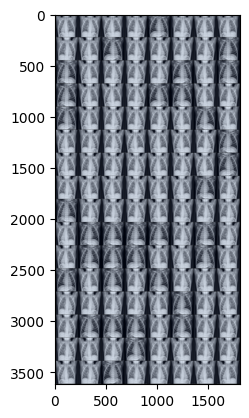

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
def imshow(img):
    img = img #/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images, normalize=True))
labels


In [39]:
print(f"Normal: {train_loader.dataset.targets.count(0)}, Pneumonia: {train_loader.dataset.targets.count(1)}")


Normal: 1341, Pneumonia: 3875


In [40]:
class PneumoniaScannerModel(torch.nn.Module):
    def __init__(self, num_classes=1):
        super(PneumoniaScannerModel, self).__init__()
        self.base_model = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        for param in self.base_model.parameters():
            param.requires_grad = False

        num_out_ftrs = self.base_model.fc.out_features
        self.fc = torch.nn.Linear(num_out_ftrs, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

model = PneumoniaScannerModel().to(device)


In [45]:
model_pickle_path = "../Model/PneumoniaScannerModel.pth"
learning_rate = 0.001
epochs = 20


In [42]:

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer with learning rate


In [43]:
neptune_run["criterion"] = str(torch.nn.BCELoss())
neptune_run["optimizer"] = str(torch.optim.Adam(model.parameters(), lr=learning_rate))
neptune_run["learning_rate"] = learning_rate
neptune_run["epochs"] = epochs
neptune_run["batch_size"] = batch_size
neptune_run["dataset_size"] = len(train_dataset)


In [44]:


for epoch in range(epochs):
    epoch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for image, target in epoch_pbar:
        optimizer.zero_grad()

        # changing the datatype and shape
        target = target.float().view(-1, 1)

        # loading to apple mps
        image = image.to(device)
        target = target.to(device)
        
        output = model(image)
        loss = criterion(output, target)
        
        predictions = (output > 0.5).float()

        target_np = target.cpu().detach().numpy().flatten()
        predictions_np = predictions.cpu().detach().numpy().flatten()

        # Calculate the number of correct predictions   
        correct_predictions += (predictions_np == target_np).sum()
        total_samples += target.size(0)

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples

    neptune_run["Training/Epoch Loss"].log(avg_loss)
    neptune_run["Training/Epoch Accuracy"].log(accuracy)

    #epoch_pbar.set_postfix(loss=avg_loss, accuracy=accuracy)
    tqdm.write(f"Epochs: [{epoch+1}/{epochs}] | Train Loss: {avg_loss:.4f} | Train Accuracy: {accuracy:.4f}")

torch.save(model.state_dict(), model_pickle_path)

neptune_run.stop()


Epoch 1/20: 100%|██████████| 41/41 [03:25<00:00,  5.00s/batch]


Epochs: [1/20] | Train Loss: 0.2383 | Train Accuracy: 0.9816


Epoch 2/20: 100%|██████████| 41/41 [03:38<00:00,  5.33s/batch]


Epochs: [2/20] | Train Loss: 0.0377 | Train Accuracy: 1.0000


Epoch 3/20: 100%|██████████| 41/41 [03:30<00:00,  5.13s/batch]


Epochs: [3/20] | Train Loss: 0.0186 | Train Accuracy: 1.0000


Epoch 4/20: 100%|██████████| 41/41 [03:46<00:00,  5.52s/batch]


Epochs: [4/20] | Train Loss: 0.0128 | Train Accuracy: 1.0000


Epoch 5/20: 100%|██████████| 41/41 [03:59<00:00,  5.84s/batch]


Epochs: [5/20] | Train Loss: 0.0089 | Train Accuracy: 1.0000


Epoch 6/20: 100%|██████████| 41/41 [04:12<00:00,  6.15s/batch]


Epochs: [6/20] | Train Loss: 0.0061 | Train Accuracy: 1.0000


Epoch 7/20: 100%|██████████| 41/41 [03:50<00:00,  5.61s/batch]


Epochs: [7/20] | Train Loss: 0.0055 | Train Accuracy: 1.0000


Epoch 8/20: 100%|██████████| 41/41 [03:28<00:00,  5.09s/batch]


Epochs: [8/20] | Train Loss: 0.0042 | Train Accuracy: 1.0000


Epoch 9/20: 100%|██████████| 41/41 [03:34<00:00,  5.22s/batch]


Epochs: [9/20] | Train Loss: 0.0030 | Train Accuracy: 1.0000


Epoch 10/20: 100%|██████████| 41/41 [03:38<00:00,  5.33s/batch]


Epochs: [10/20] | Train Loss: 0.0029 | Train Accuracy: 1.0000


Epoch 11/20: 100%|██████████| 41/41 [03:30<00:00,  5.14s/batch]


Epochs: [11/20] | Train Loss: 0.0026 | Train Accuracy: 1.0000


Epoch 12/20: 100%|██████████| 41/41 [03:30<00:00,  5.13s/batch]


Epochs: [12/20] | Train Loss: 0.0022 | Train Accuracy: 1.0000


Epoch 13/20: 100%|██████████| 41/41 [03:41<00:00,  5.39s/batch]


Epochs: [13/20] | Train Loss: 0.0019 | Train Accuracy: 1.0000


Epoch 14/20: 100%|██████████| 41/41 [03:46<00:00,  5.53s/batch]


Epochs: [14/20] | Train Loss: 0.0017 | Train Accuracy: 1.0000


Epoch 15/20: 100%|██████████| 41/41 [03:33<00:00,  5.22s/batch]


Epochs: [15/20] | Train Loss: 0.0017 | Train Accuracy: 1.0000


Epoch 16/20: 100%|██████████| 41/41 [03:37<00:00,  5.30s/batch]


Epochs: [16/20] | Train Loss: 0.0012 | Train Accuracy: 1.0000


Epoch 17/20: 100%|██████████| 41/41 [03:25<00:00,  5.01s/batch]


Epochs: [17/20] | Train Loss: 0.0015 | Train Accuracy: 1.0000


Epoch 18/20: 100%|██████████| 41/41 [03:27<00:00,  5.06s/batch]


Epochs: [18/20] | Train Loss: 0.0014 | Train Accuracy: 1.0000


Epoch 19/20: 100%|██████████| 41/41 [03:19<00:00,  4.88s/batch]


Epochs: [19/20] | Train Loss: 0.0014 | Train Accuracy: 1.0000


Epoch 20/20: 100%|██████████| 41/41 [03:21<00:00,  4.91s/batch]


Epochs: [20/20] | Train Loss: 0.0010 | Train Accuracy: 1.0000


RuntimeError: Parent directory Model does not exist.